# What Happens To BERT Embeddings During Fine-tuning?

Codebase: https://github.com/r05323028/What_happens_to_bert_embeddings_during_fintuning

In this notebook, we'll try to reproduce [**What Happens To BERT Embeddings During Fine-tuning?**](https://www.aclweb.org/anthology/2020.blackboxnlp-1.4/) which was accepted by **EMNLP2020**, **Proceedings of the Third BlackboxNLP Workshop on Analyzing and Interpreting Neural Networks for NLP**

### Todo list
- [x] RSA Similarity
- [x] Structural Probe
- [ ] Edge Probe
- [ ] Layer Ablations
- [ ] Out-of-domain Behavior

## Brief Introduction to BERT

BERT is a stack encoder inspired by **Attention is all you need**. The main idea of BERT is to train a large encoder contains huge informations. Then, several NLP tasks can use BERT to finetune downstream decoder to solve specific tasks.

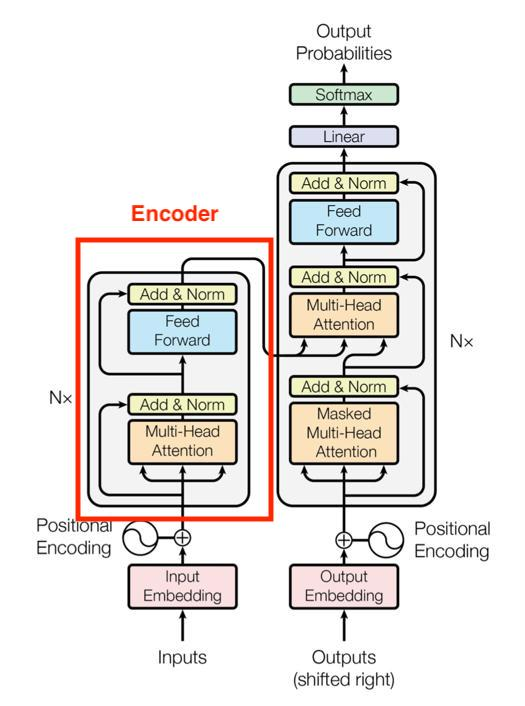

For detials of how to pretrain or finetune BERT, you can see the [original paper](https://arxiv.org/pdf/1810.04805.pdf).

## Layerwise Analysis of BERT

The first time I saw people do layerwise analysis of BERT was at **CIKM2019, Beijing**. I went to this conference with my colleague and saw this paper - [**How Does BERT Answer Questions? A Layer-Wise Analysis of Transformer Representations**](https://arxiv.org/abs/1909.04925). It performs PCA to project word representations of all layers to a 2D space after BERT inferernces questions and extracts answers. Then, we can see that bottom layers of BERT contain low-level informations such as **Topics**, **POS**, **Dependencies** and top layers contain high-level informations such as **Question-Fact matching**, **Answering extraction**.

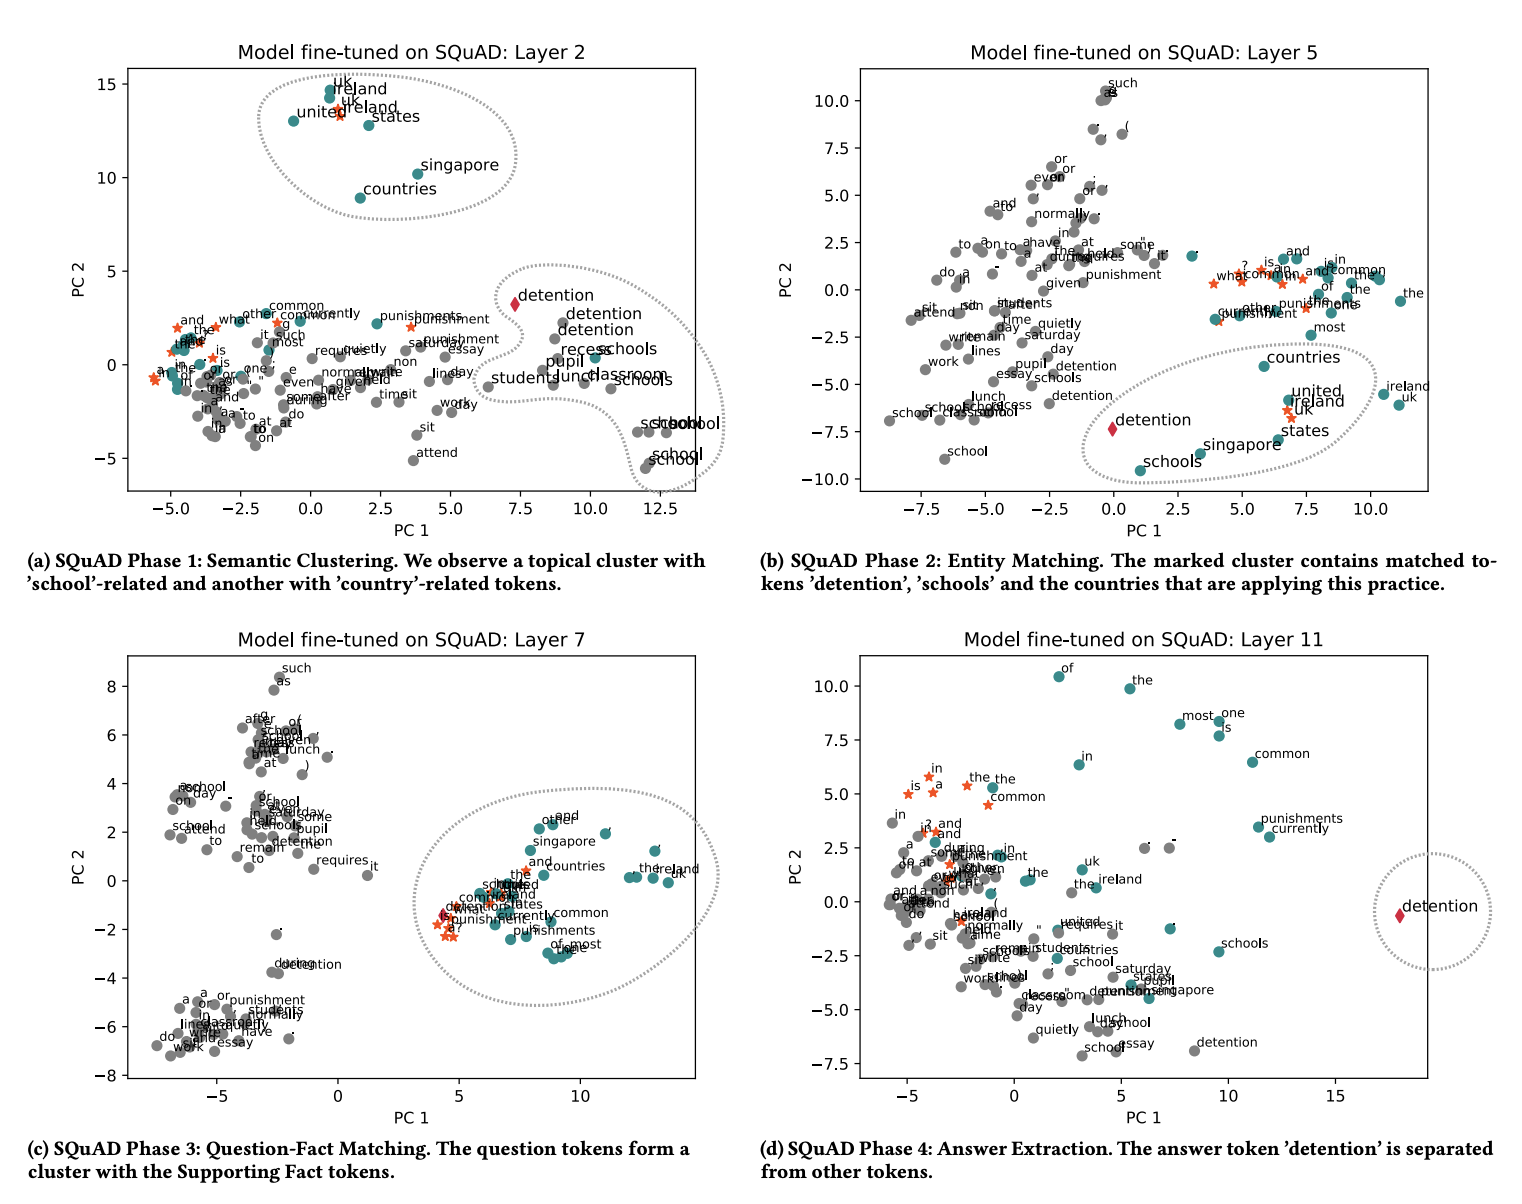

The authors build a cool interactive website. If you are interesting in this, you can go to this [page](https://visbert.demo.datexis.com/).

## Load Data & Model

In this section, we load wiki dataset, `bert-base-uncased` which is a pretrained model announced by Google, `bert-mnli` which was finetuned by `glue/mnli` dataset and `bert-squad` which is finetuned by `squad`.

In [1]:
import os, sys
import re
from typing import Dict
import tensorflow as tf

sys.path.append(os.path.abspath('..'))

import conllu
import tensorflow as tf
from scipy.stats import spearmanr
import numpy as np
import plotly
from transformers import TFBertModel, BertTokenizer, BertConfig
import tensorflow_datasets as tfds
import pandas as pd
import plotly.express as px
from tqdm.notebook import trange

from bert_repro.plot import BertComparator
from bert_repro.probe.model import TwoWordProbe
from bert_repro.probe.data import ProbeDataset
from bert_repro.probe.trainer import build_label_mask

In [2]:
plotly.offline.init_notebook_mode()

In [3]:
bert_base_config = BertConfig(
    output_hidden_states=True,
    output_attentions=True
)

bert_mnli_config = BertConfig(
    output_hidden_states=True,
    output_attentions=True
)

bert_squad_config = BertConfig(
    output_hidden_states=True,
    output_attentions=True
)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
bert_base = TFBertModel.from_pretrained('bert-base-uncased', config=bert_base_config)
bert_mnli = TFBertModel.from_pretrained("../models/mnli", config=bert_mnli_config)
bert_squad = TFBertModel.from_pretrained('../models/squad', config=bert_squad_config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at ../models/mnli were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are ini

In [6]:
wiki = tfds.load('wiki40b/en', data_dir='../data')

INFO:absl:Load dataset info from ../data/wiki40b/en/1.3.0
INFO:absl:Field info.config_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.config_description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset wiki40b (../data/wiki40b/en/1.3.0)
INFO:absl:Constructing tf.data.Dataset for split None, from ../data/wiki40b/en/1.3.0


## Representational Similarity Analysis (RSA)

We used pretrained model & finetuned models to get hidden states of layers and compare their `cosine similarity`.

In [7]:
bc_mnli = BertComparator(bert_base, bert_mnli, tokenizer)
bc_squad = BertComparator(bert_base, bert_squad, tokenizer)

In [8]:
mnli_result = bc_mnli.get_layer_cos_sim_in_data(wiki['train'])

In [9]:
squad_result = bc_squad.get_layer_cos_sim_in_data(wiki['train'])

In [10]:
results = [(l_idx, sim, 'base_squad') for l_idx, sim in enumerate(squad_result)] + \
          [(l_idx, sim, 'base_mnli') for l_idx, sim in enumerate(mnli_result)]

In [11]:
df = pd.DataFrame(results, columns=['layer_index', 'similarity', 'versus'])

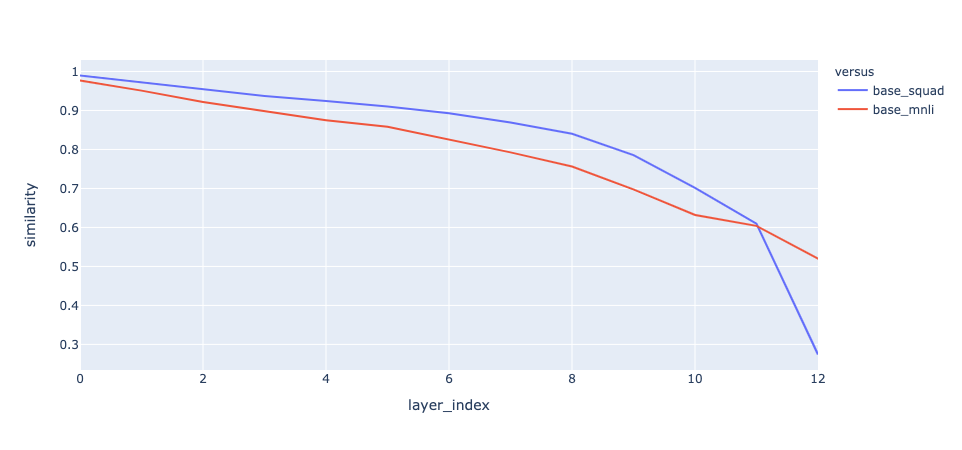

In [12]:
px.line(df, x='layer_index', y='similarity', color='versus')

Due to the above figure, we can conclude that

- hidden states' distributions changed dramatically the top layer.
- the model finetuned on the complicated task (SQuAD) changed more dramatically than the model finetuned on the simple task (GLUE/MNLI).

## Structural Probe

Structural probe is a method to evaluate whether a word representation model learns syntax structure in paragraphs. The main idea is, it supposes that syntax tree structures can be remained after linear projecting. The following figure shows this concept intuitively.

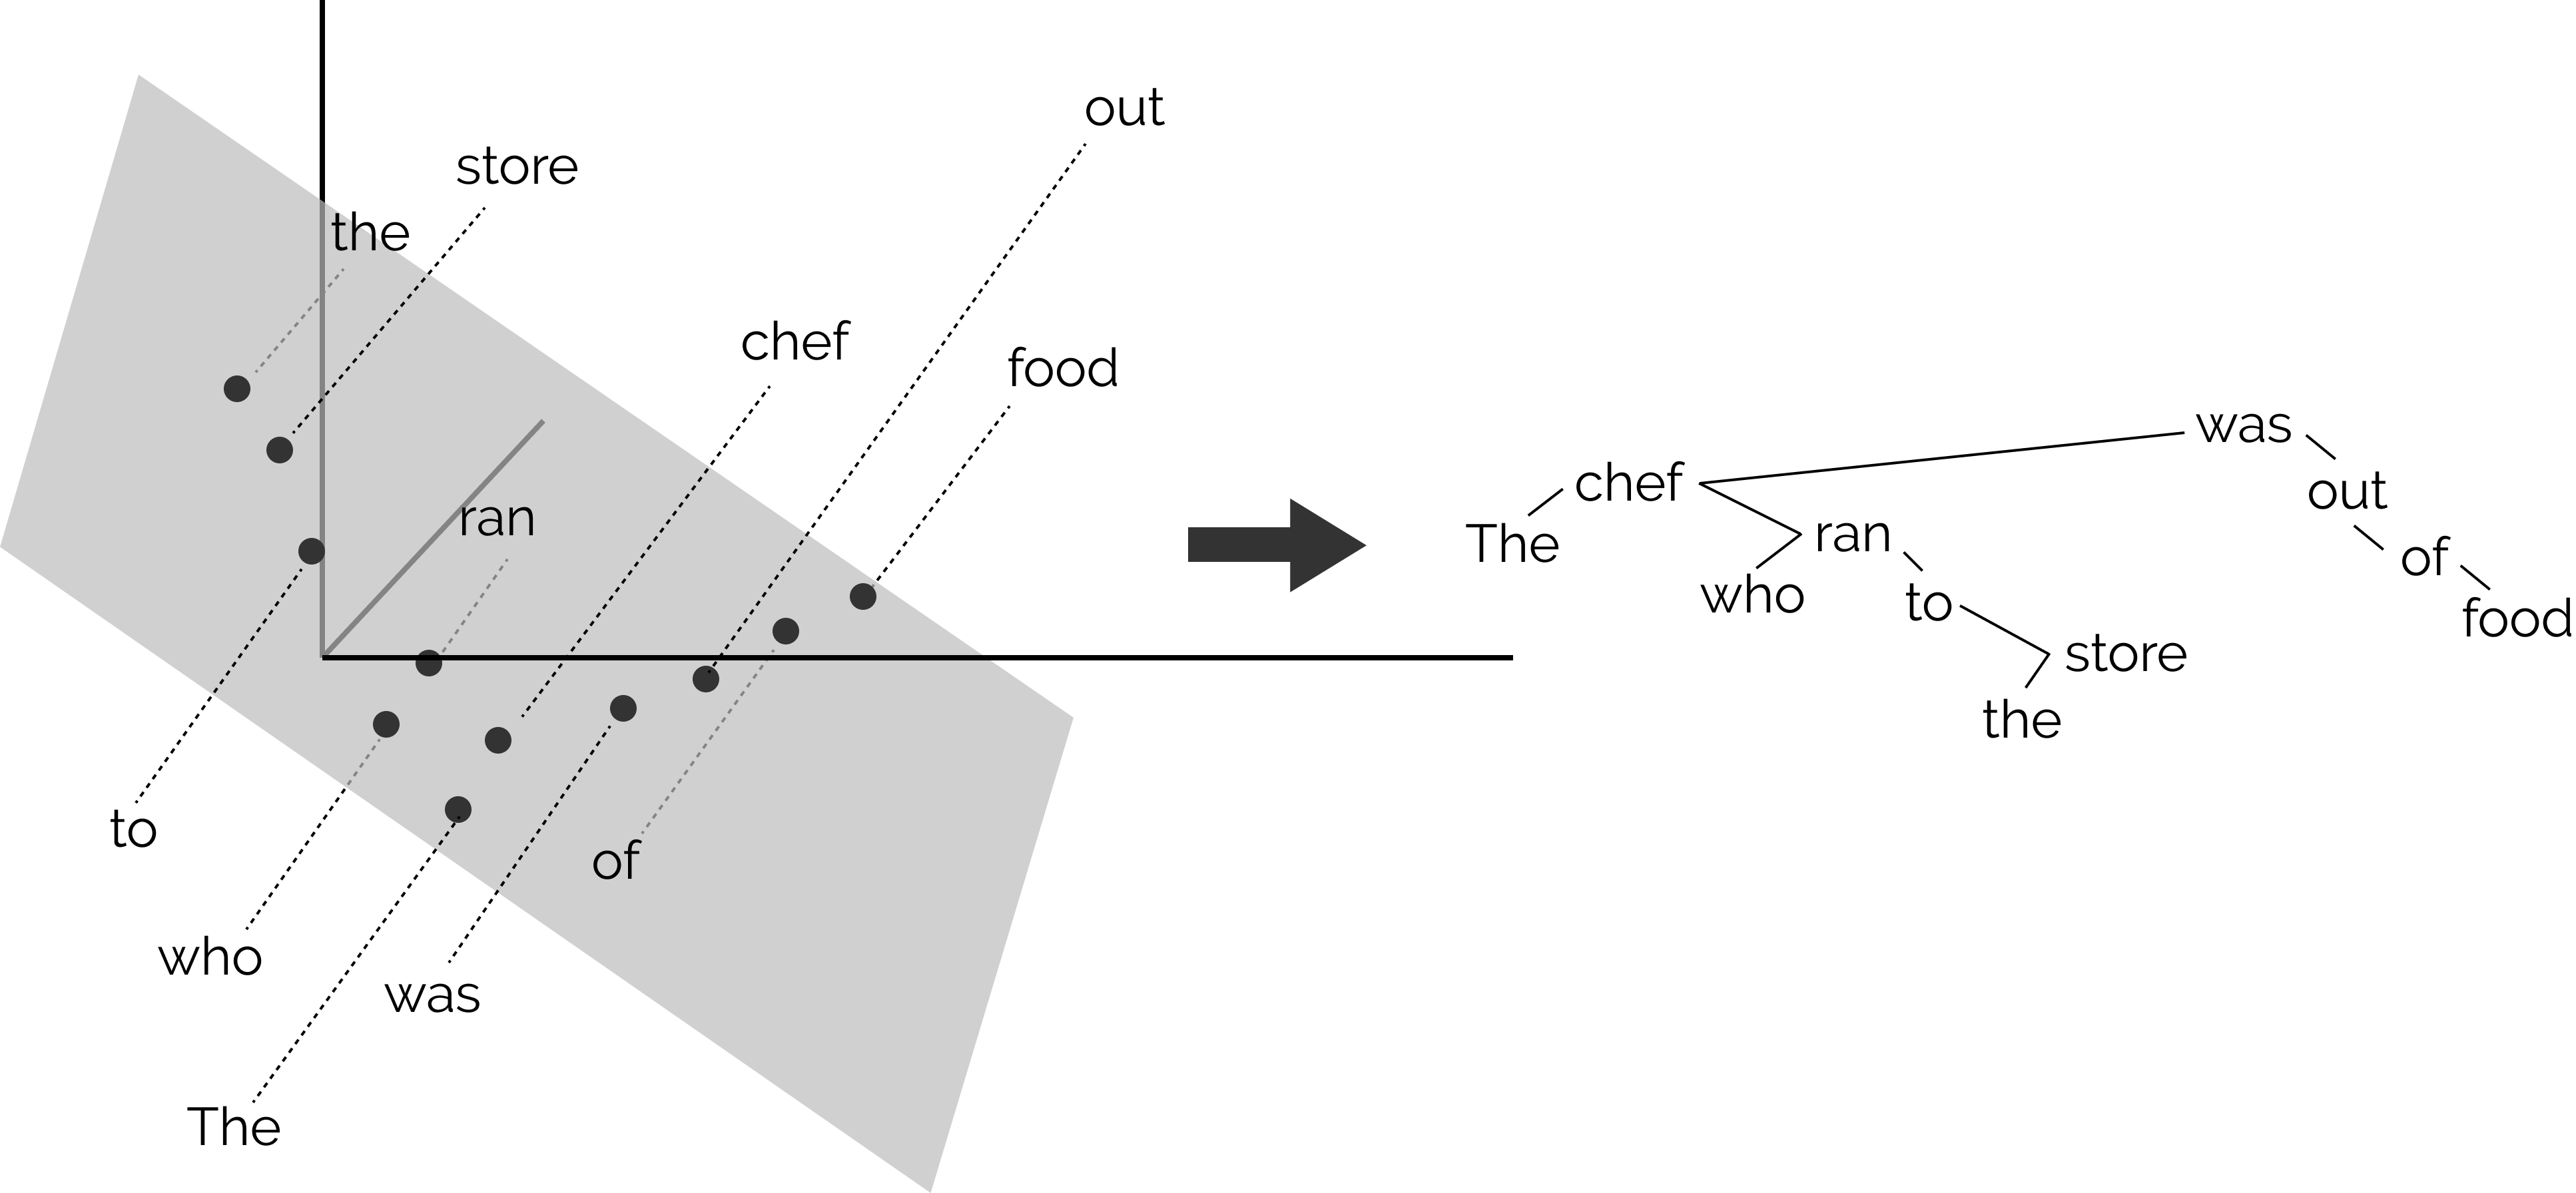

So, how do we evaluate it? the answer is, we can train a probe model to predict **the number of edges between every pair tokens**. In order to do gradient descent in Euclidean space, we define **the number of edges between every pair tokens** as **distance**, $d(w_i, w_j)$.

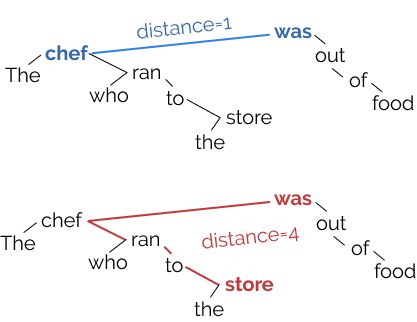

The following figure shows that we can use a probe model to project word representations to the subspace which persists the syntax tree structure of the sentence **if the language model really learned syntax**.

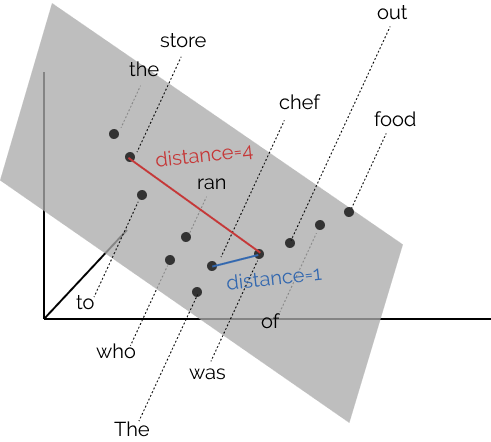

As stated above, we used a linear projecting to map **hidden state pairs** to a subspace.

$$
{\bf B}({\bf h}_i - {\bf h}_j)
$$

where, ${\bf B}$ is the linear transformation matrix, ${\bf h}$ is the hidden states. Then, we can define $d_{B}$ as the distance after linear projecting.

$$
d_{{\bf B}}({\bf h}_i, {\bf h}_j) = ({\bf B}({\bf h}_i - {\bf h}_j))^T ({\bf B}({\bf h}_i - {\bf h}_j))
$$

Finally, we can perform gradient descent to minimize the loss:

$$
\min_{{\bf B}} \sum_{l} \frac{1}{|s_l|^2} \sum_{i, j} (d(w_i, w_j) - d_{{\bf B}}({\bf h}_i, {\bf h}_j))
$$

In [13]:
PROBE_RANK = 128
BERT_DIM = 768
TRAIN_DATASET = "../data/ud-treebanks-v2.7/UD_English-EWT/en_ewt-ud-train.conllu"

In [14]:
base_probe_model = TwoWordProbe(BERT_DIM, PROBE_RANK)
mnli_probe_model = TwoWordProbe(BERT_DIM, PROBE_RANK)
squad_probe_model = TwoWordProbe(BERT_DIM, PROBE_RANK)

In [15]:
base_probe_model.load_weights('../models/bert-base-probe/model')
mnli_probe_model.load_weights('../models/bert-mnli-probe/model')
squad_probe_model.load_weights('../models/bert-squad-probe/model')

In [16]:
dataset = ProbeDataset(TRAIN_DATASET)

In [17]:
def get_spearman_corr(preds, golds, sent_lengths):
    sps = []
    
    for pred, gold, l in zip(preds, golds, sent_lengths):
        try:
            spearman = spearmanr(pred, gold).correlation[:l, :l]
        except:
            continue
        sps.append(spearman)
    return np.mean([np.mean(i) for i in sps])

In [18]:
def get_spearman_corr_for_all_layers(bert, probe_model, tokenizer, dataset, n_samples=100, batch_size = 32):
    outputs = {}
    assert batch_size <= n_samples, "Batch size > n_samples"
    
    for layer_index in trange(bert.config.num_hidden_layers, desc='get_spearman'):
        # tf.data.Dataset generates (hidden_states, probe_rank, length)
        tf_dataset = tf.data.Dataset.from_generator(
            lambda: dataset.build_pairs_distance_generator(bert, tokenizer, layer_index=layer_index, return_length=True, batch_size=batch_size),
            output_types=(tf.float32, tf.float32, tf.int32),
        )
        
        spearmans = []
        
        for example in tf_dataset.take(n_samples):
            hs, probe_rank, length = example
            max_length = tf.reduce_max(length)
            label_mask = build_label_mask(length, max_length)
            probe_outputs = probe_model(hs)
            probe_outputs = probe_outputs * label_mask
            probe_rank = probe_rank * label_mask
            spearman = get_spearman_corr(probe_outputs, probe_rank, length)
            spearmans.append(spearman)
            
        outputs[layer_index] = spearmans
        
    return outputs

In [19]:
outputs = {}
models = [
    ('base', bert_base, base_probe_model),
    ('mnli', bert_mnli, mnli_probe_model),
    ('squad', bert_squad, squad_probe_model),
]
for name, bert, probe_model in models:
    output = get_spearman_corr_for_all_layers(bert, probe_model, tokenizer, dataset, n_samples=100, batch_size=32)
    outputs[name] = output

get_spearman:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



get_spearman:   0%|          | 0/12 [00:00<?, ?it/s]

get_spearman:   0%|          | 0/12 [00:00<?, ?it/s]

In [20]:
outputs_ = []

for name, results in outputs.items():
    for l_index, sim in results.items():
        outputs_.append((name, l_index, np.mean(sim)))

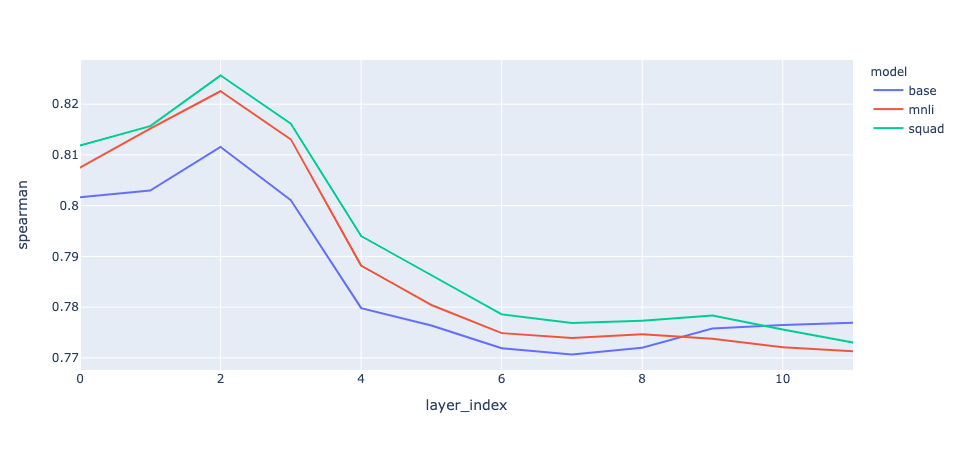

In [21]:
px.line(
    pd.DataFrame(outputs_, columns=['model', 'layer_index', 'spearman']), 
    x='layer_index', 
    y='spearman', 
    color='model'
)

Due to the above figure, we can conclude that,

- although we got a different graph compared to original paper, we can still find similar patterns.
    - bottom layers contain more syntax informations than top layers.
    - BERT still retains syntax structures after fine-tuning.

## References

- structural probe codebase: https://github.com/john-hewitt/structural-probes
- structural probe blog: https://nlp.stanford.edu//~johnhew//structural-probe.html
- structural probe paper: https://nlp.stanford.edu/pubs/hewitt2019structural.pdf
- transformers: https://huggingface.co/
- conll 2017 (universal dependencies): https://universaldependencies.org/